# Gaussian Process regression for fitting interatomic potentials
# Part 2

# Cluster 

### Inferring a pair interaction model based on total energy information

For certain types of atomic systems, the total, inherently many-body interaction energy may be approximated by pair interaction terms: $E(\mathbf{r}_1, \mathbf{r}_2, \ldots \mathbf{r}_N) \approx \sum^N_{i<j} E_2(r_{ij})$, where the system consists of $N$ atoms with Cartesian coordinates $\mathbf{r}_1, \mathbf{r}_2, \ldots \mathbf{r}_N$. $E_2$ is a function of interatomic distances $r_{ij}$. Example where this works well are noble gases or certain types of metals.

In this part of the workshop, we will study a toy problem, where the total interaction energy consists explicitly of two-body terms, and the aim of the workshop is to recover the original model. We will use configurations of clusters of 12-19 atoms, and the interaction energy (the underlying function we are trying to fit) will be the Lennard-Jones model for the total energy

$$
E^{LJ}(r_{ij}) = 4\left(\frac1{r_{ij}^{12}} - \frac1{r_{ij}^6} \right)
$$

* $E^{LJ}(r_{ij})$ : is the potential energy between two particles at a distance r.
* $\frac {1}{{r_{ij}}^{12}}$ (The attractive term): which represents long-range attractions due to van der waals forces.
* $\frac {1}{{r_{ij}^6}}$ (The repulsive term): which represent the repulsion due to overlapping electron clouds.




To calculate the total energy of a cluster of atoms using the Lennard-Jones potential, you would sum the pairwise interactions between all pairs of atoms in the cluster. The total energy is the sum of all these pairwise contributions. This approach is commonly used in molecular dynamics simulations to model the behavior of clusters of atoms or molecules.

It's worth noting that while the Lennard-Jones potential is a useful and simple model, it's a highly simplified representation of atomic interactions and may not accurately describe all types of molecular interactions. More complex force fields and potential energy functions are often used in realistic simulations of molecular systems.

In [1]:
import numpy as np
import pandas as pd
import GPy

from ase.io import read
import nglview

from IPython.display import display

#%pylab inline
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_context('talk')
import matplotlib.pyplot as plt


#from google.colab import output
#output.enable_custom_widget_manager()




In [2]:
# We load the cluster configurations
cluster_trajectory = read("clusters.xyz", index=":")
print(len(cluster_trajectory), len( cluster_trajectory[1])) # the clusters consist of 12 to 19 atoms

400 19


In [3]:
#nglview.show_asetraj(cluster_trajectory)

In [4]:
cluster_trajectory[0]

Atoms(symbols='Ar19', pbc=False)


The term "Ar19 cluster atoms" refers to a cluster of 19 argon (Ar) atoms. In this context:

* **Ar**: This is the chemical symbol for argon, which is a **noble gas** and one of the chemical elements on the periodic table (atomic number 18). Argon is a colorless, odorless, and inert gas that is commonly found in the Earth's atmosphere. It is often used in various scientific and industrial applications.

* **19 cluster atoms**: This specifies the number of argon atoms in the cluster. In the context of cluster chemistry and physics, clusters are assemblies of a small number of atoms or molecules (typically ranging from a few to several hundred) that are held together by weak intermolecular forces or chemical bonds. Studying the properties of such clusters can provide insights into the behavior of matter at the nanoscale.

"Ar19 cluster atoms" would refer to a specific arrangement of 19 argon atoms, and the properties of such a cluster could be of interest in the study of cluster physics or chemistry. These clusters may exhibit unique properties, such as electronic structure or reactivity, that differ from those of individual atoms or larger bulk materials.

In [5]:
# For each cluster, we calculate the total energy and collect it in cluster_energy
# here we don't implement the QM potential energy that we did in the last approach, but instead we use the Lennard Jones
#model which is a simple pair model.
from ase.calculators.lj import LennardJones
p = LennardJones()

cluster_energy = [] # 400 clusters, 400 energies
for a in cluster_trajectory:
    a.set_calculator(p)
    cluster_energy.append(a.get_potential_energy()) # the true labels are calculated with lennardjonnes
    # these energies are for clusters

In [6]:
# We split the data in train and test set.


from sklearn.model_selection import train_test_split

cluster_train, cluster_test, cluster_energy_train, cluster_energy_test = train_test_split(
    cluster_trajectory, cluster_energy, test_size=0.4)

The model we use for the total energy is

$$E_{cluster} = \sum_{i<j} {\mathcal GP}(r_{ij}).$$

* $E_{cluster}$ : is the energy for a single cluster.
* ${\mathcal GP}(r_{ij})$ : is the gaussian process prediction calculation (prediction) of the pair-wise energies.

To fit the GP, we need to obtain all pair-wise distances in each configuration.
we need to create this sum Gaussian regression to predict the energy for each cluster, rather than the a single interaction.

In [7]:
from ase.neighborlist import neighbor_list

def get_distances(atoms_array,cutoff=3.0):
    distances = []
    for a in atoms_array:
        i, j, d = neighbor_list('ijd', a, cutoff)
        d = d[i < j]  # We exclude duplicates
        distances.append(d)
    return distances # List of arrays of distances for each cluster

In [8]:
distances_train = get_distances(cluster_train)
distances_test = get_distances(cluster_test)
distances_train[0] # for the first cluster.

array([1.76969166, 2.05495086, 1.12143691, 1.70448644, 2.12851977,
       1.08286367, 1.1529282 , 1.2102962 , 1.04047441, 1.54608224,
       1.86495945, 2.39121853, 2.63286325, 2.07515455, 1.03397911,
       2.03164964, 1.06469793, 1.32512357, 1.98012367, 1.76784419,
       1.11880625, 1.02926362, 1.23437848, 1.57032979, 1.03529508,
       2.08667966, 1.8557923 , 1.24993267, 1.33347292, 2.15462429,
       1.85312753, 2.39545804, 1.58786832, 1.34306952, 2.56189725,
       1.3503161 , 1.82758492, 1.25160959, 2.03586264, 1.17879649,
       2.01790003, 1.17714466, 2.64935611, 2.53437923, 2.4956663 ,
       2.75221017, 2.08064155, 1.19160288, 1.25756994, 2.05651679,
       2.07027989, 2.90384359, 1.15964607, 2.44655176, 2.26609183,
       1.058619  , 1.12157121, 2.60797231, 1.72859169, 2.0088176 ,
       1.59026276, 1.28079775, 1.46707366, 1.90840675, 2.11883053,
       2.06669467, 2.86445125, 2.98263661, 1.76077673, 2.13999621,
       2.20081745, 1.20508828, 1.18787743, 1.94912216, 2.03066

The target data (cluster) is the sum of Gaussian Process models (for each interactions). We need to find the covariance of total energies (for a cluster): if the covariance of two pair interactions terms is $k(r,r')$, the covariance of two total energies of two configurations (clusters) $A$ and $B$ is the sum of covariance functions:

$$\langle E_A E_B \rangle = \sum_{ij \in A, i'j' \in B} k(r_{ij},r_{i'j'})$$

the covariance between two total enegies for two clusters A and B, is the sum of correlation between the distances in cluster A and B.


The following class implements this idea.

In [9]:
from scipy.spatial.distance import cdist

class SumGP:
    """Class implementing a sum Gaussian Process"""

    def __init__(self, length_scale=1.0, function_range=1.0, error=0.1):
        """Initialise the class with the GP hyperparameters"""
        self.length_scale = length_scale
        self.function_range = function_range
        self.error = error

    def update_covariance(self):
        """Update the covariance matrix"""
        self.covariance = self.sum_covariance(self.training_data,self.training_data)
        self.covariance += np.eye(len(self.covariance))*self.error**2

    def update_weights(self):
        """Update the GP model weights"""
        self.weights = np.linalg.solve(self.covariance,self.training_target)

    def update_gp(self):
        """Update the covariance and the GP model weights"""
        self.update_covariance()
        self.update_weights()

    def set_training_data(self,distances,energies):
        """Add training data and perform the fit"""
        self.training_data = distances
        self.training_target = energies
        self.update_gp()

    def set_parameters(self,length_scale=None,function_range=None,error=None):
        """Update GP hyperparameters"""
        changed = False
        if length_scale is not None:
            self.length_scale = length_scale
            changed = True
        if function_range is not None:
            self.function_range = function_range
            changed = True
        if error is not None:
            self.error = error
            changed = True
        if changed:
            self.update_gp()

    def predict(self,distances, do_variance=False, do_covariance=False):
        """
        Predicts total energy for a set of pairwise distances,
        optionally with variances
        """
        k = self.sum_covariance(distances,self.training_data)
        mean = np.dot(k,self.weights)
        res = {"mean":mean}
        if do_variance:
            variance = []
            for _d,_k in zip(distances,k):
                variance.append(self.error**2+
                    self.sum_covariance([_d],[_d])[0,0] -
                           np.dot(_k, np.linalg.solve(self.covariance,_k))
                )
            res["variance"] = variance

        if do_covariance:
            covariance = self.sum_covariance(distances,distances)
            res["covariance"] = ( np.eye(len(distances))*self.error**2 +
                                 covariance - np.dot(k,np.linalg.solve(self.covariance,k.T)) )

        return res

    def sum_covariance(self, d1, d2):
        """Sum covariance function"""
        covariance = []
        for i, _d1 in enumerate(d1):
            _c_row = []
            for j, _d2 in enumerate(d2):
                distance_matrix = cdist(
                    np.array(_d1)[:,None],
                    np.array(_d2)[:,None],
                    'euclidean')

                _c = np.sum(self.function_range**2*np.exp(
                            -0.5*distance_matrix**2/self.length_scale**2)) # Kernel for <E_A E_B>
                _c_row.append(_c)
            covariance.append(_c_row)
        covariance = np.array(covariance)
        return covariance


In [10]:
distances_train[0]

array([1.76969166, 2.05495086, 1.12143691, 1.70448644, 2.12851977,
       1.08286367, 1.1529282 , 1.2102962 , 1.04047441, 1.54608224,
       1.86495945, 2.39121853, 2.63286325, 2.07515455, 1.03397911,
       2.03164964, 1.06469793, 1.32512357, 1.98012367, 1.76784419,
       1.11880625, 1.02926362, 1.23437848, 1.57032979, 1.03529508,
       2.08667966, 1.8557923 , 1.24993267, 1.33347292, 2.15462429,
       1.85312753, 2.39545804, 1.58786832, 1.34306952, 2.56189725,
       1.3503161 , 1.82758492, 1.25160959, 2.03586264, 1.17879649,
       2.01790003, 1.17714466, 2.64935611, 2.53437923, 2.4956663 ,
       2.75221017, 2.08064155, 1.19160288, 1.25756994, 2.05651679,
       2.07027989, 2.90384359, 1.15964607, 2.44655176, 2.26609183,
       1.058619  , 1.12157121, 2.60797231, 1.72859169, 2.0088176 ,
       1.59026276, 1.28079775, 1.46707366, 1.90840675, 2.11883053,
       2.06669467, 2.86445125, 2.98263661, 1.76077673, 2.13999621,
       2.20081745, 1.20508828, 1.18787743, 1.94912216, 2.03066

In [12]:
points_set1 = np.array([[1, 2], [3, 4], [5, 6]])
points_set2 = np.array([[2, 2], [4, 4], [6, 6]])

# Calculate pairwise Euclidean distances
distances = cdist(points_set1, points_set2, metric='euclidean')

print((1)**2*np.exp( -0.5*distances**2/(1)**2))

[[6.06530660e-01 1.50343919e-03 1.25015287e-09]
 [8.20849986e-02 6.06530660e-01 1.50343919e-03]
 [3.72665317e-06 8.20849986e-02 6.06530660e-01]]


In [13]:
# Calculate pairwise Euclidean distances for a single cluster with itself.
distances = cdist(distances_train[0][:, None], distances_train[0][:, None], metric='euclidean')

distances

array([[0.        , 0.28525919, 0.64825476, ..., 0.62469701, 0.0582534 ,
        0.57830873],
       [0.28525919, 0.        , 0.93351395, ..., 0.9099562 , 0.34351259,
        0.86356792],
       [0.64825476, 0.93351395, 0.        , ..., 0.02355775, 0.59000136,
        0.06994603],
       ...,
       [0.62469701, 0.9099562 , 0.02355775, ..., 0.        , 0.56644361,
        0.04638828],
       [0.0582534 , 0.34351259, 0.59000136, ..., 0.56644361, 0.        ,
        0.52005533],
       [0.57830873, 0.86356792, 0.06994603, ..., 0.04638828, 0.52005533,
        0.        ]])

In [14]:
# Initialise the GP with hyperparameters
sum_gp = SumGP(length_scale=0.25, error=0.5, function_range=5.0)

In [15]:
# Add data and fit the model
sum_gp.set_training_data(distances_train, cluster_energy_train)

### Optimising the hyperparameters
To find the optimal hyperparameters (`length_scale`, `error` and `function_range`) we can try maximising the likelihood of the model:

$$
\log L = -\frac{1}{2} \mathbf{y}^T \mathbf{K}^{-1} \mathbf{y} - \frac{1}{2} \log |\mathbf{K}| - \frac{n}{2} \log 2 \pi$$

Remember, the two main components of this expression balance the goodness of the fit (first term) and the complexity of the model (second term).


* $- \frac {1}{2} log{∣K∣} :$ This term represents the complexity penalty of the model. It quantifies the complexity of the Gaussian process and encourages a simpler model when the determinant of the covariance matrix (
$K$) is large. A simpler model generally corresponds to a smoother and less wiggly regression function.
* $ − \frac{n}{2}log{2π} :$ This term is a constant that depends on the number of data points (
n) and ensures that the log-likelihood is properly scaled.



Implement a log likelihood function for the `SumGP` class using the template provided below. Use the numpy function [np.linalg.slogdet](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html) to compute the log of the determinent of the covariance matrix. For the first term of the log likelihood expression, notice that $\mathbf{K}^{-1} \mathbf{y} = \mathbf{w}$, the fitted weights of the model, stored as `self.weights` in the `SumGP` class.


In [16]:
def get_likelihood(self):
    """Calculate GP likelihood"""

    res = 0.0
    ### BEGIN SOLUTION
    sign, logdet = np.linalg.slogdet(self.covariance)
    res = (-0.5*np.dot(self.training_target, self.weights)
     -0.5*logdet +
     -0.5*len(self.training_target)*np.log(2*np.pi))
    ### END SOLUTION

    return res

SumGP.get_likelihood = get_likelihood

Compute the log likelihood as a function of the `length_scale` hyperparameter. Plot the results, and determine the optimal parameter, given the other two hyperparameters remain fixed.

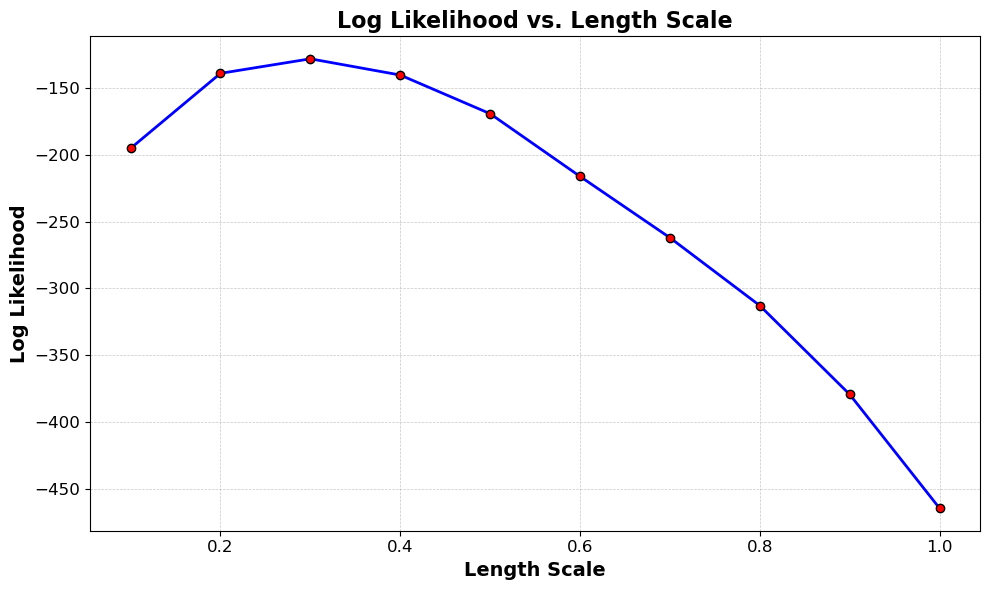

In [71]:
sum_gp = SumGP(length_scale=0.25,error=0.5,function_range=5.0)
sum_gp.set_training_data(distances_train,cluster_energy_train)


length_scale_array = np.linspace(0.1, 1.0, 10)
likelihood_array = []
for _l in length_scale_array:
    sum_gp.set_parameters(length_scale=_l)
    likelihood_array.append(sum_gp.get_likelihood())

plt.figure(figsize=(10, 6))
plt.plot(length_scale_array, likelihood_array, color='blue', linewidth=2, linestyle='-', marker='o', markersize=6, markerfacecolor='red', markeredgewidth=1, markeredgecolor='black')
plt.xlabel('Length Scale', fontsize=14, fontweight='bold')
plt.ylabel('Log Likelihood', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.title('Log Likelihood vs. Length Scale', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Set the `length_scale` hyperparameter to the optimal value you found above, and plot the two-body interatomic potential model as a function of interatomic distances, with error bars, and compare it with the known solution, the Lennard-Jones model. You need to set the range of distances where you want to inspect the model - start from short distances and go beyond the cutoff (3.0) we used.

Here is some sample code to do predictions to get you started

```python
# Predict pair interaction energies using the GP model
r_min = ...
r_max = ...
r_test = np.linspace(r_min,r_max)[:,None]
test_gp = sum_gp.predict(r_test,do_variance=True,do_covariance=True)
e_test_gp = test_gp["mean"]
v_test_gp = test_gp["variance"]
c_test_gp = test_gp["covariance"]
```

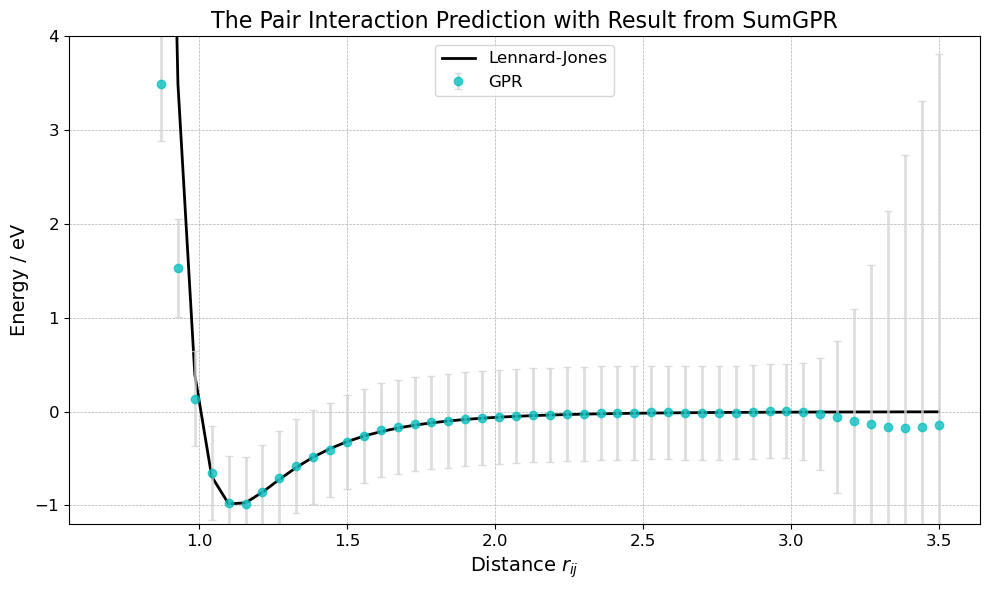

In [70]:
sum_gp.set_parameters(length_scale=0.3)
r_min = 0.7
r_max = 3.5

r_test = np.linspace(r_min,r_max)[:,None]

# Lennard-Jones model - the target of the GP model
e_test_lj = 4*(1/r_test**12-1/r_test**6)

# Predict pair interaction energies using the GP model
test_gp = sum_gp.predict(r_test,do_variance=True,do_covariance=True)
e_test_gp = test_gp["mean"]
v_test_gp = test_gp["variance"]
c_test_gp = test_gp["covariance"]

yerror = np.sqrt(v_test_gp)
plt.figure(figsize=(10, 6))
plt.plot(r_test, e_test_lj, label='Lennard-Jones', color='black', linewidth=2)
plt.errorbar(r_test, e_test_gp, yerr=yerror, fmt='o', color='c', ecolor='lightgray', 
             elinewidth=2, capsize=3, label='GPR', alpha=0.75)
plt.ylim([-1.2, 4])
plt.xlabel('Distance $r_{ij}$', fontsize=14)
plt.ylabel('Energy / eV', fontsize=14)
plt.legend(fontsize=12, loc='best')
plt.title('The Pair Interaction Prediction with Result from SumGPR', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.tight_layout()
plt.show()




In the code cell below, using the `np.random.multivariate_normal` function (as seen in the lecture), with `test_gp["mean"]` as the mean and `test_gp["covariance"]` as the covariance, where `test_gp` is the result of calling `sum_gp.predict()`), draw samples from the posterior. Plot the results together with the known target function (Lennard-Jones pairwise interactions). 

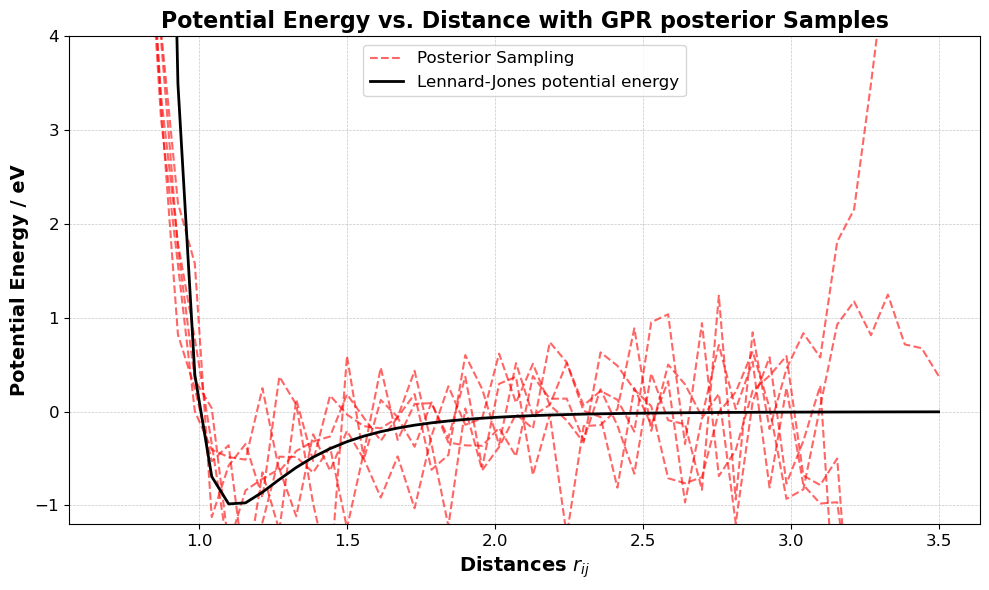

In [74]:
import numpy as np
import matplotlib.pyplot as plt
N_sample = 5

plt.figure(figsize=(10, 6))
for i in range(N_sample):
    s_test_gp = np.random.multivariate_normal(e_test_gp, c_test_gp)
    if i != 4:
        plt.plot(r_test, s_test_gp, 'r--', alpha=0.6)  # Red dashed lines with transparency
    else:
        plt.plot(r_test, s_test_gp, 'r--', alpha=0.6, label='Posterior Sampling')  # Add label to the last sample

plt.plot(r_test, e_test_lj, 'k-', linewidth=2, label='Lennard-Jones potential energy')


plt.ylim([-1.2, 4])


plt.xlabel('Distances $r_{ij}$', fontsize=14, fontweight='bold')
plt.ylabel('Potential Energy / eV', fontsize=14, fontweight='bold')


plt.legend(fontsize=12, loc='best')
plt.title('Potential Energy vs. Distance with GPR posterior Samples', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.tight_layout()
plt.show()


##### Adapting the code used above to predict GP energies (i.e., using `sum_gp.predict()`), evaluate the GP model on the test set `distances_test` we generated by splitting the original data set. Plot the correlation of the target energy and the prediction, with error bars.

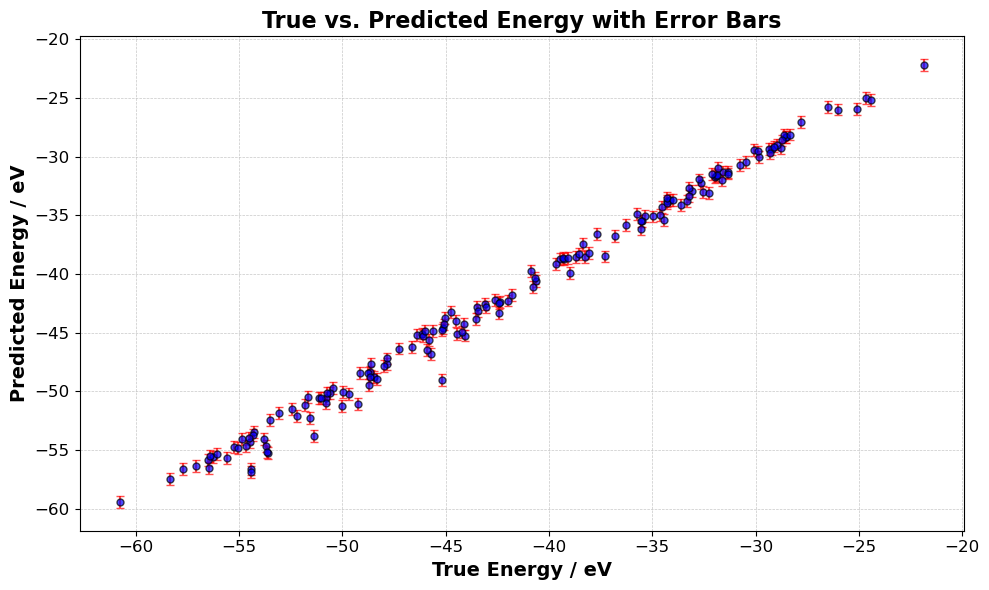

In [77]:
cluster_gp = sum_gp.predict(distances_test, do_variance=True)
cluster_energy_predict = cluster_gp["mean"]
cluster_energy_variance = cluster_gp["variance"]

plt.figure(figsize=(10, 6))
plt.errorbar(cluster_energy_test, cluster_energy_predict,
             yerr=np.sqrt(cluster_energy_variance), fmt='o', markersize=5,
             markerfacecolor='blue', markeredgewidth=1, markeredgecolor='black',
             ecolor='red', elinewidth=1.5, capsize=3, alpha=0.7)
plt.xlabel('True Energy / eV', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Energy / eV', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.title('True vs. Predicted Energy with Error Bars', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
